# Nuts and Bolts Project
**Course**: CS 4732

**Instr**: Dr. Hung

Test 2, Part 1 (Take Home)

## Description
You are asked to classify parts coming down a conveyor line as nuts, bolts or washers.
Please write your program in any programming languages to implement this pattern recognition
problem. Some images are provided for your experiments.

Example Image:
<img src="https://github.com/mtfuller/CS4732-Nuts-and-Bolts/raw/master/img/bolts2.jpg" alt="Example Image" style="width: 400px;"/>

Please note that this is not just *image segmentaion* problem. It is a *pattern recognition* problem. You
are encouraged to create your own images similar to the one shown below as long as your images
have nuts, bolts and washers.

Turn in:
 1. One page for your recognition system design,
 2. Your program, and
 3. Your demo.

## Design
To classify the parts in the image, we need to design a solution that can accomplish three major tasks:
 - Segment the individual objects in the image.
 - Extract a certain number of features each segmented object.
 - Classify the object based on the extracted features.
 
Here is an overview of the entire process:
![Example Image](https://github.com/mtfuller/CS4732-Nuts-and-Bolts/raw/master/img/NutsBoltsDataflow.png "Example Nuts/Bolts Image")

To implement the solution, I have chosen to use Python along with various libraries such as OpenCV, TensorFlow, Keras, etc. in order to more easily implement the designed process.

## Object Segmentation
Objective: create a process to take an input image and find all possible objects and create a create a list of all matrices that contain objects to use for feature extraction.

First, let's load an example image:

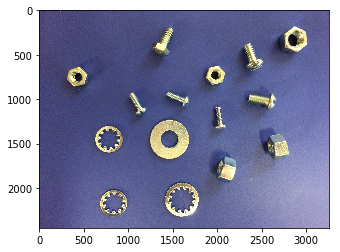

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

input_file = './img/bolts.png'

original = cv2.imread(input_file,1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

A big question to answer is: what is the best way to find and extract the parts from the image? We need a way to segment the image in a way that allows us to find each individual part. Color-based segmentation using K-Means would not be a good fit for this problem. An alternative is to use morphological operators to perform texture segmentation on the object.

Reference on OpenCV Morphological Operators: [OpenCV Python Tutorial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

We can use a *Morphological Gradient* to place outlines around each object in the image:

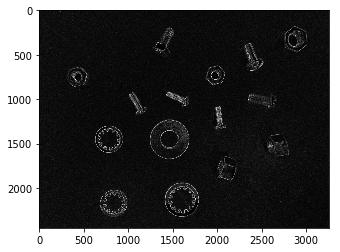

In [2]:
small_kernel = np.ones((5,5),np.uint8)

gray_image = cv2.imread(input_file,0)
gradient = cv2.morphologyEx(gray_image, cv2.MORPH_GRADIENT, small_kernel)
plt.imshow(gradient,cmap='gray')

Now, let's find the binary regions in the image that represent the objects. We can do this by applying a binary threshold and then close the image:

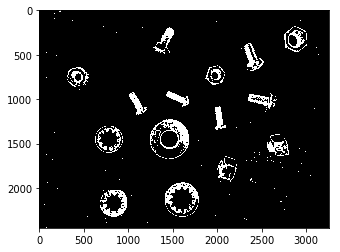

In [3]:
med_kernel = np.ones((9,9),np.uint8)

# Closing Image
closing = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, med_kernel)

# Thresholding
ret,thresh1 = cv2.threshold(closing,35,255,cv2.THRESH_BINARY)

# th3 = cv2.adaptiveThreshold(gradient,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)

# Closing Image
# closing = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, med_kernel)

plt.imshow(thresh1,cmap='gray')

At this point, we have a binary image where most white pixels are a part of one of the objects. Now we need to extract the individual objects from the image. We can do this by calculating each object's minimum bounding box.

Total contours found: 604
Number of Objects: 15


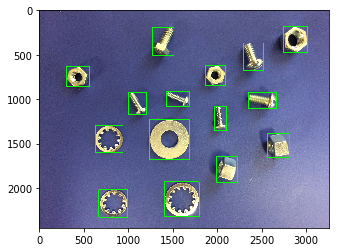

In [4]:
rects, contours, h = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

new = original.copy()

min_area = 0.001
max_area = 0.9

parts = []

print("Total contours found:",len(contours))
num_of_objects = 0
for i in range(len(contours)):
    cnt = contours[i]
    x,y,w,h = cv2.boundingRect(cnt)
    area_ratio = (w*h) / (new.shape[0] * new.shape[1])
    if (area_ratio >= min_area and area_ratio <= max_area):
        num_of_objects += 1
        parts.append(tuple([x,y,w,h]))
        new = cv2.rectangle(new,(x,y),(x+w,y+h),(0,255,0),10)

print("Number of Objects:",num_of_objects)
plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))

Now, we have calculated the minimum bounding box for each object in the image. The object segmentation phase is now complete.

## Feature Extraction
The next phase in creating a solution to this pattern recognition is to extract specific features from each object. 

Let's evalutate some possible features:
 - **Color**: Not a good feature, parts can come in multiple colors.
 - **Size**: Not a good feature, parts often vary in size.
 - **Outer Shape of Object**: Good feature, but difficult to calculate/quantify.
 - **Bounding Box Scale**: Good feature (bolts tend to be in rectangles), simple to calculate.
 - **Lightness**: Not good feature, parts have similar luster.
 - **Number of Corners**: Possibly a good feature, relatively simple to calculate.
 - **Object Perimeter to Box Perimeter**: Possibly a good feature, but relatively difficult to calculate.
 - **Object Area to Box Area** Possibly a good feature, simple to calculate.

We will now walk through extracting the following features from one of the objects:
 - Object Area to Box Area
 - Bounding Box Scale
 - Number of Corners
 - Outer Shape of Object
 - Object Perimeter to Box Perimeter
 
Let's grab one of the objects found from the object segmentation phase:

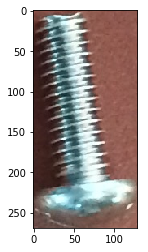

In [5]:
test_part = parts[6]

x, y, w, h = test_part

part_img = original[y:y+h, x:x+w]

plt.imshow(part_img)

### Object Area to Box Area
The object area to box area (area ratio) of the pixels used to represent the object to the total number of pixels in the image. This ratio will always be $<= 1$. The hope is that objects like nuts and washers will have lower ratios than bolts.
$$Area_{Ratio} = \frac{P_{Object}}{P_{Total}}$$

To calculate this, we must:
 1. Threshold the image so that we have a binary image.
 2. Count the number of pixels that equal 1.
 3. Calculate the area ratio

Number of Object Pixels: 9749
Total Number of Pixels: 34701
Area Ratio: 28.09%


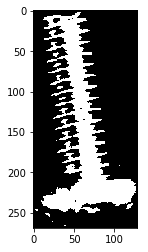

In [6]:
ret,th1 = cv2.threshold(cv2.cvtColor(part_img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)
plt.imshow(th1, cmap='gray')

pixels_object = np.count_nonzero(th1)
pixels_box = th1.shape[0]*th1.shape[1]

print("Number of Object Pixels:",pixels_object)
print("Total Number of Pixels:",pixels_box)

area_ratio = pixels_object / pixels_box

print("Area Ratio:","{:3.2f}%".format(area_ratio*100))

### Bounding Box Scale
This feature is essentially a value that represents how "stretched" or "squashed" the bounding box is. If the bounding box is very close to a square, then it is more likely to be a washer or possibly a nut. If the bounding box is more rectangular, it is more likely to be a bolt. The Bouding Box Scale is calculated by the following:
$$Scale_{Box} = \left\{\begin{matrix}
\frac{w}{h}\space if\space w <= h\\ 
\frac{h}{w} \space if\space w > h
\end{matrix}\right.$$

In [7]:
def find_box_scale(width, height):
    if width <= height:
        return w/float(h)
    else:
        return h/float(w)

scale_box = find_box_scale(w,h)
print("Bounding Box Scale:", scale_box) #Should be close to 1.

Bounding Box Scale: 0.4795539033457249


### Number of Corners
This feature runs a corner detection algorithm to find how many corners are detected in the object. This may be a good feature. Bolts have a many sharp ridges all along its threading, so they might have a high number of corners.

**NOTE:** I may need to normalize this feature in some way. Not sure best way. I will include just the number of corners in the dataset, as well as the number of pixels in the image, so that I can play around with this feature to see if dividing by the image "area" will better normalize it.

To find the corners within the image, we will use the Harris Corner Algorithm. Luckily, it has been implemented in OpenCV. All we need to do is run the Harris Corner Algorithm and count the number of corners detected:

Number of Corners: 506


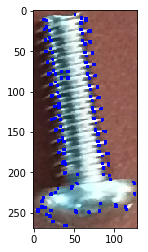

In [8]:
gray = np.float32(th1)
gray = closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, med_kernel)

dst = cv2.cornerHarris(gray,2,3,0.05)

number_of_corners = np.count_nonzero(dst[dst>0.03*dst.max()])
print("Number of Corners:",number_of_corners)

dst = cv2.dilate(dst,None)

corner_img = part_img.copy()
corner_img[dst>0.03*dst.max()]=[0,0,255]

plt.imshow(corner_img)

### Outer Shape of Object
This seems to be one of the most promising features. The outer shape of each part class is very distinct from each other. To quantify this, we need to define some sort of metric that measures how "circular" the object is. I have defined a metric to measure such "circularity". First, we need to calculate the outer perimeter of the shape, then we calculate the circumference of an ideal circle for the bounding box of the image. Finally, we calculate the Mean Squared Error between the perimiter of the shape and the circumference of the ideal circle.

$$E_{Circularity} = \space \frac{\mid A_{Object} - A_{Circle} \mid}{Area_{Box}}$$

Object Area: 8655.0
Ideal Radius: 134.5
Circle Area: 56832.19650160275
Circularity Error: 48177.19650160275
Circularity Percent Error: 66.579%


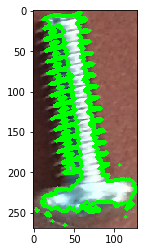

In [9]:
rects, object_conts, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shape_img = part_img.copy()
cv2.drawContours(shape_img,object_conts,-1,(0,255,0),3)

contour_areas = [cv2.contourArea(c) for c in object_conts]

area_object = contour_areas[np.argmax(contour_areas)]
print("Object Area:",area_object)

radius = part_img.shape[0]/2.0 if part_img.shape[0] > part_img.shape[1] else part_img.shape[1]/2.0
print("Ideal Radius:",radius)

area_circle = np.pi * radius**2
print("Circle Area:",area_circle)

E_circularity = abs(area_object - area_circle) / ((2*radius)**2)
print("Circularity Error:",abs(area_object - area_circle))
print("Circularity Percent Error:","{:.3f}%".format(E_circularity*100))

plt.imshow(shape_img)

### Normalized Perimeter
The final feature to gather is the outer perimeter of the object, but we need to normalize it using the dimensions of the bouding box.
$$P_{Norm} = \frac{P_{Object}}{2w+2l}$$

Object Perimeter: 2179.866215109825
Image Perimeter: 796.0
Normalized Perimeter: 2.739


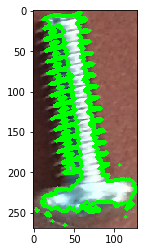

In [10]:
rects, object_conts, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
perimeter_img = part_img.copy()
cv2.drawContours(shape_img,object_conts,-1,(0,255,0),3)

contour_perimeters = [cv2.arcLength(c,True) for c in object_conts]

perimeter_object = contour_perimeters[np.argmax(contour_perimeters)]
print("Object Perimeter:",perimeter_object)

print("Image Perimeter:",(2.0*part_img.shape[0] + 2.0*part_img.shape[1]))

perimeter_norm = perimeter_object / (2.0*part_img.shape[0] + 2.0*part_img.shape[1])
print("Normalized Perimeter:","{:.3f}".format(perimeter_norm))

plt.imshow(shape_img)

Now that we have defined and can extract each feature, we have completed the feature extraction phase.

## Classification
In this final phase, we will utilize all that we have done to build and train a classification system in order to recognize and classify each object. 

To do this, we must work through the machine learning design process:
 1. Collect data in order to build a dataset.
 2. Explore the dataset and look for patterns.
 3. Prepare data for training, **NOT** validation.
 4. Choose a learning model.
 5. Fine tune the model.
 6. Evaluate.
 
So, let's get crackin'.

### 1. Collecting Data for the Dataset
Blah Blah Blah...